Figures for paper.  Determine values of $q(t)$ for past dates.

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, widgets
import data
import matplotlib.dates as mdates
import warnings
import csv
import deconvolution
import datetime
from covid_forecast import *
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)

palette = plt.get_cmap('tab10')

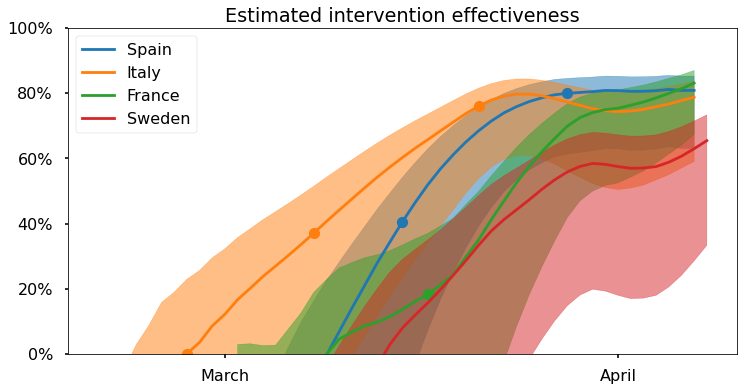

In [33]:
beta_low = 0.14
beta_high = 0.35
beta = 0.27
plt.figure(figsize=(12,6))
for ii, region in enumerate(['Spain','Italy','France','Sweden']):#'Austria','Germany','United Kingdom']):
    N = data.get_population(region)
    smooth = True
    gamma = 0.07

    ifr = avg_ifr(region)
    data_dates, cum_cases, cum_deaths = data.load_time_series(region,smooth)
    data_start = mdates.date2num(data_dates[0])  # First day for which we have data
    daily_cases = np.insert(np.diff(cum_cases),0,cum_cases[0])

    u0, offset, inf_dates, I, R, new_infections = \
        infer_initial_data(cum_deaths,data_start,ifr,gamma,N,method='deconvolution',extended_output=1)

    S = N - R - I
    q = 1 - N*new_infections/(beta*S*I)
    q_low = 1 - N*new_infections/(beta_low*S*I)
    q_high = 1 - N*new_infections/(beta_high*S*I)
    start = np.where(I>N/10000)[0][0]
    plt.plot_date(data_dates[start:-offset],q[start:-offset]*100,'-',color=palette(ii),label=region)
    plt.fill_between(data_dates[start:-offset],q_low[start:-offset]*100,q_high[start:-offset]*100,
                     '-',color=palette(ii),alpha=0.5)
    if region in data.lockdown_start:
        for ld in data.lockdown_start[region]:
            lockdown_date = datetime.strptime(ld,'%m-%d-%Y')
            i = np.where(np.array([datetime.strftime(d,'%m-%d-%Y') for d in data_dates])==ld)
            plt.plot_date([lockdown_date],q[i]*100,'o',color=palette(ii))
        
    #q_past, _ = assess_intervention_effectiveness(cum_deaths,N,ifr,data_dates,slope_penalty=100)
    #plt.plot_date(data_dates[-offset:],q_past(np.arange(offset))*100,'--',color=palette(ii))
    
plt.ylim(0,100)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.yaxis.set_major_formatter(yticks)
plt.title('Estimated intervention effectiveness');
plt.legend()

plt.savefig('past_intervention_countries.pdf')

In [34]:
avg_ifr('Sweden')

0.011529910811969577

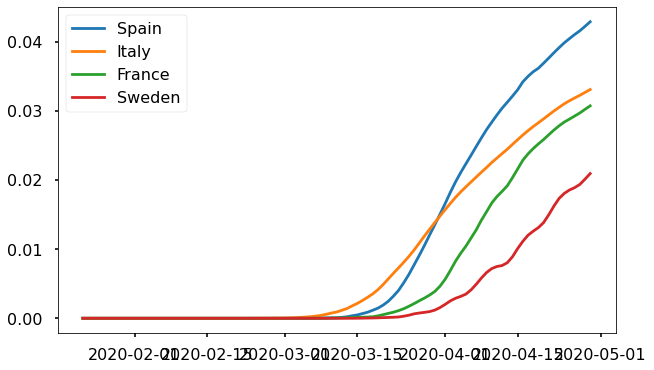

In [40]:
regions = ['Spain','Italy','France','Sweden']
for region in regions:
    N = data.get_population(region)
    data_dates, cum_cases, cum_deaths = data.load_time_series(region,smooth)
    plt.plot(data_dates,cum_deaths/N/avg_ifr(region))
    plt.legend(regions)

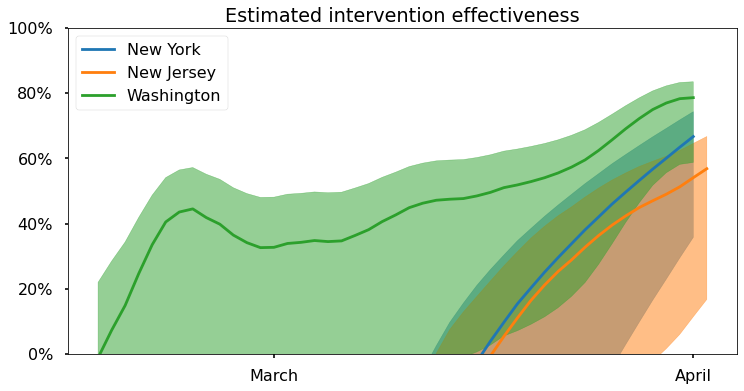

In [30]:
plt.figure(figsize=(12,6))
for ii, region in enumerate(['New York','New Jersey','Washington']):#,'California','Michigan']):
    N = data.get_population(region)
    smooth = True
    gamma = 0.07
    beta = 0.27
    ifr = avg_ifr(region)
    data_dates, cum_cases, cum_deaths = data.load_time_series(region,smooth)
    data_start = mdates.date2num(data_dates[0])  # First day for which we have data
    daily_cases = np.insert(np.diff(cum_cases),0,cum_cases[0])

    u0, offset, inf_dates, I, R, new_infections = \
        infer_initial_data(cum_deaths,data_start,ifr,gamma,N,method='deconvolution',extended_output=1)

    S = N - R - I
    q = 1 - N*new_infections/(beta*S*I)
    q_low = 1 - N*new_infections/(beta_low*S*I)
    q_high = 1 - N*new_infections/(beta_high*S*I)
    start = np.where(I>N/10000)[0][0]
    plt.plot_date(data_dates[start:-offset],q[start:-offset]*100,'-',color=palette(ii),label=region)
    plt.fill_between(data_dates[start:-offset],q_low[start:-offset]*100,q_high[start:-offset]*100,
                     '-',color=palette(ii),alpha=0.5)
    
    #q_past, _ = assess_intervention_effectiveness(cum_deaths,N,ifr,data_dates,slope_penalty=100)
    #plt.plot_date(data_dates[-offset:],q_past(np.arange(offset))*100,'--',color=palette(ii))
    
plt.ylim(0,100)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.yaxis.set_major_formatter(yticks)
plt.title('Estimated intervention effectiveness');
plt.legend()

plt.savefig('past_intervention_states.pdf')

In [ ]:
def backfit_q(region,interval=7):
    N = data.get_population(region)
    data_dates, total_cases, cum_deaths = data.load_time_series(region)
    data_start = mdates.date2num(data_dates[0])  # First day for which we have data

    u0, offset, inf_dates, active_infections, recovered, new_infections = \
        infer_initial_data(cum_deaths,data_start,ifr,gamma,N,method='deconvolution',extended_output=1)
    
    #u0, mttd, inferred_data_dates, active_infections, cum_recovered, _= \
    #        infer_initial_data(cum_deaths,data_start,ifr,gamma,N,'deconvolution',True)
    
    def objective(q):
        qlong = np.hstack([ [qval]*interval for qval in q])
        nn = len(qlong)
        active_infections_trunc = active_infections[:nn]  # Should be chopping off the start instead of end
        #active_infections_trunc = active_infections[-nn:]  # why doesn't this work?
        modeled_daily_infections = (1.-qlong)*beta*active_infections_trunc  # Need to include q.
        M = itod_matrix(len(daily_infections));
        pred_daily_deaths = M@daily_infections*ifr
        pred_cum_deaths = np.cumsum(pred_daily_deaths)
        return np.linalg.norm(np.linspace(0,1,nn)*(pred_cum_deaths[:nn]-cum_deaths[:nn]),2) + \
                10*np.sum(np.abs(np.diff(qlong))) + \
                1e1*np.sum(qlong)
    
    nnn = int(len(active_infections)/interval)
    bounds = optimize.Bounds(np.zeros(nnn),np.ones(nnn))  # Keep q between 0 and 1
    result=optimize.minimize(objective,x0=np.ones(int(len(active_infections)/interval))*0.,bounds=bounds,
                             method='slsqp')
    qq = result.x
    return qq